# Backtracking Logistic regression

This notebook is dedicated to numerical experiments for Logistic regression with $L^1$-regularization. The function to minimize is:

$$\min_{x\in\mathbb{R}^n} \frac{\lambda_1}{2\|A^Tb\|_\infty}\sum_{j=1}^m \log \left(1+e^{-b_ja_j^T x}\right)+\frac{\lambda_2}{2}\|x\|^2+\|x\|_1,$$
where $A\in \mathcal{M}_{m\times n}(\mathbb{R})$, $b\in\mathbb{R}^m$, $b_j\in\left\{-1,1\right\}$ and $a_j=\text{row}_j(A)$. This example was treated in "Adaptive restart of accelerated gradient methods under local quadratic growth condition" of Fercoq and Qu. 

Let us define $f:x\mapsto \frac{\lambda_1}{2\|A^Tb\|_\infty}\sum_{j=1}^m \log \left(1+e^{-b_ja_j^T x}\right)+\frac{\lambda_2}{2}\|x\|^2$ and $h:x\mapsto\|x\|_1$. We have that 
$$\nabla f(x)=-\frac{\lambda_1}{2\|A^Tb\|_\infty}\sum_{j=1}^m  \frac{b_ja_j}{1+e^{b_ja_j^T x}}+\lambda_2 x.$$
An upper bound for the Lipschitz constant of $\nabla f$ is $L=\frac{\lambda_1\|A^Tb\|^2}{8\|A^Tb\|_\infty}+\lambda_2$.

### Importing libraries, generating data and operators

In [1]:
#Importing libraries
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import scipy.linalg as spl
import time

In [2]:
#Importing additional packages: algorithms.py contains the algorithms to apply and visualizer.py is useful to plot loss functions.
import os.path
if not os.path.isfile('./visualizer.py'):
    !wget https://github.com/HippolyteLBRRR/Composite_optimization/raw/main/visualizer.py
if not os.path.isfile('./algorithms.py'):
    !wget https://github.com/HippolyteLBRRR/Composite_optimization/raw/main/algorithms.py
from algorithms import *
from visualizer import *

--2023-02-21 15:29:46--  https://github.com/HippolyteLBRRR/Composite_optimization/raw/main/algorithms.py
Résolution de github.com (github.com)… 140.82.121.3
Connexion à github.com (github.com)|140.82.121.3|:443… connecté.
requête HTTP transmise, en attente de la réponse… 302 Found
Emplacement : https://raw.githubusercontent.com/HippolyteLBRRR/Composite_optimization/main/algorithms.py [suivant]
--2023-02-21 15:29:46--  https://raw.githubusercontent.com/HippolyteLBRRR/Composite_optimization/main/algorithms.py
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 39829 (39K) [text/plain]
Sauvegarde en : « algorithms.py »

algorithms.py       100%[===================>]  38,90K  --.-KB/s    ds 0,001s  

2023-02-21 15:29:47 (56,2 MB/s) — « algorithms.py » sauveg

In [3]:
#Functions aiming to avoid overflow values inside exponential function (for example there is a problem computing
#log(1+exp(x)) for large values of x)

def log_exp(a,x):
    #returns (log(1+exp(-a^T x)))
    z=-np.dot(a,x)
    return np.maximum(z, 0) + np.log(np.exp(-np.absolute(z)) + 1)

def log_func(x):
    #returns (1/(1+e^x))
    return .5 * (1 + np.tanh(-.5 * x))

In [4]:
#Definition of the operators

def f_LR(x,A,b,ba,l1,l2):
    return l1*np.sum(log_exp(ba,x))+l2*npl.norm(x,2)**2/2
def Df_LR(x,A,b,ba,l1,l2):
    return l2*x-l1*np.sum(np.dot(ba.T,np.diag(log_func(np.dot(ba,x)))),axis=1)
def operators_LR(A,b,l1,l2):
    ba=np.dot(A.T,np.diag(b)).T
    L1=l1/(2*np.max(np.absolute(ba)))
    f = lambda x: f_LR(x,A,b,ba,L1,l2)
    h = lambda x: npl.norm(x,1)
    F = lambda x: f(x)+h(x)
    Df = lambda x: Df_LR(x,A,b,ba,L1,l2)
    proxh = lambda x,s:(x/(np.absolute(x)-1*(x==0)))*(np.absolute(x)-s)*(np.absolute(x)-s>0)
    return F,f,h,Df,proxh

In [62]:
# Random sampling of A and b and computation of the corresponding operators
n=30000
m=100
A=np.random.rand(m,n)
b=np.random.randint(0,2,m)*2-1
ba=np.dot(A.T,np.diag(b)).T
# Regularization parameters (same choices as Fercoq and Qu)
l1=1e1#1e2#1e0#
L_log=l1*npl.norm(A,2)**2/(8*np.max(np.absolute(ba)))
l2=L_log/(10*n)
L=L_log+l2 # Computation of the upper bound of the Lipschitz constant


x0=(np.random.uniform(-1,1,n))
exit_crit=lambda x,xm:npl.norm(x-xm,2) #critère d'arrêt -> norme du gradient composite
sp=lambda x,y:np.dot(x,y) #produit scalaire associé aux vecteurs
F,f,h,Df,proxh=operators_LR(A,b,l1,l2)

In [63]:
Niter=5000 # Maximum number of iterations (backtracking iterations are not taken in account)
epsilon=1e-8 # Expected accuracy on the composite gradient


### Applying first-order methods to this problem

In [81]:
# Documentation for the algorithms:
# help(FISTA)
# help(FISTA_automatic_restart)
# help(FISTA_BT)
# help(Free_FISTA)

In [65]:
# FISTA
xFISTA,coutFISTA,ctimeFISTA=FISTA(x0,1/L,Niter,epsilon,Df,proxh,F=F,exit_crit=exit_crit,track_ctime=True)
Plot_FISTA=To_Plot(coutFISTA,"FISTA",ctimeFISTA) # To_Plot object -> visualization

In [66]:
# FISTA restart by ADLR
xAR1,coutAR1,ctimeAR1=FISTA_automatic_restart(x0,1/L,Niter,epsilon,Df,proxh,F,exit_crit=exit_crit,track_ctime=True)
Plot_AR1=To_Plot(coutAR1,"Automatic FISTA restart (ADLR)",ctimeAR1)

In [67]:
# FISTA with backtracking
L0=1 #initial estimation of the Lipschitz constant -> arbitrarily small value
rho=0.8
delta=0.95
xBT,coutBT,ctimeBT,L_BT,ite_BT=FISTA_BT(x0, L0, rho, delta, Niter, epsilon, f, Df, proxh, h, exit_crit=exit_crit, sp=sp, out_L=True,out_ite=True, exit_norm=True,track_ctime=True)
Plot_BT1=To_Plot(coutBT,"FISTA with backtracking, rho=%f, delta=%f, L0=%i"%(rho,delta,L0),ctimeBT)

In [68]:
# Free FISTA
L0=1
rho=0.8
delta=0.95
xBTR,coutBTR1,ctimeBTR1,L_BTR1,ite_BTR1=Free_FISTA(x0, L0, rho, delta, Niter, epsilon, f, h, Df, proxh, exit_crit=exit_crit, sp=sp, out_cost=True, out_L=True, out_ite=True, exit_norm=True,track_ctime=True)
Plot_BTR1=To_Plot(coutBTR1,"Free-FISTA, rho=%f, delta=%f, L0=%i"%(rho,delta,L0),ctimeBTR1)

In [69]:
# Computing an accurate approximation of the solution for visualization
xmin = Free_FISTA(xBTR, L_BTR1[-1], rho, delta, 3000, 1e-12, f, h, Df, proxh, exit_crit=exit_crit, sp=sp, out_cost=False, out_L=False, out_ite=False, exit_norm=True,track_ctime=False)

In [94]:
# help(Plot)

Help on function Plot in module visualizer:

Plot(tab, ite=True, coutmin=None, plage=None, fontsize=None, style=None, eps=1e-08)
    Fonction d'affichage de courbes de convergence.
    
    Parameters
    ----------
    
        tab : array of To_Plot
            Array containing the curves to plot and associated legends.
        ite : boolean, optional
            Boolean which states if the convergence curves are displayed
            according to the number of iterations or according to the 
            array tab[?].xaxis
        coutmin : float, optional
            Minimum F of the function to minimize.
        plage : array, optional
            Array containing two values [start,finish]. The function displays 
            the curves from the start-th iteration to the finish-th iteration.
        fontsize : integer, optional
            Fontsize of the legend.
        style : array, optional
            Array having the same size as tab, containing the curve style of 
           

Text(0, 0.5, '$\\log(F(x_k)-\\hat F)$')

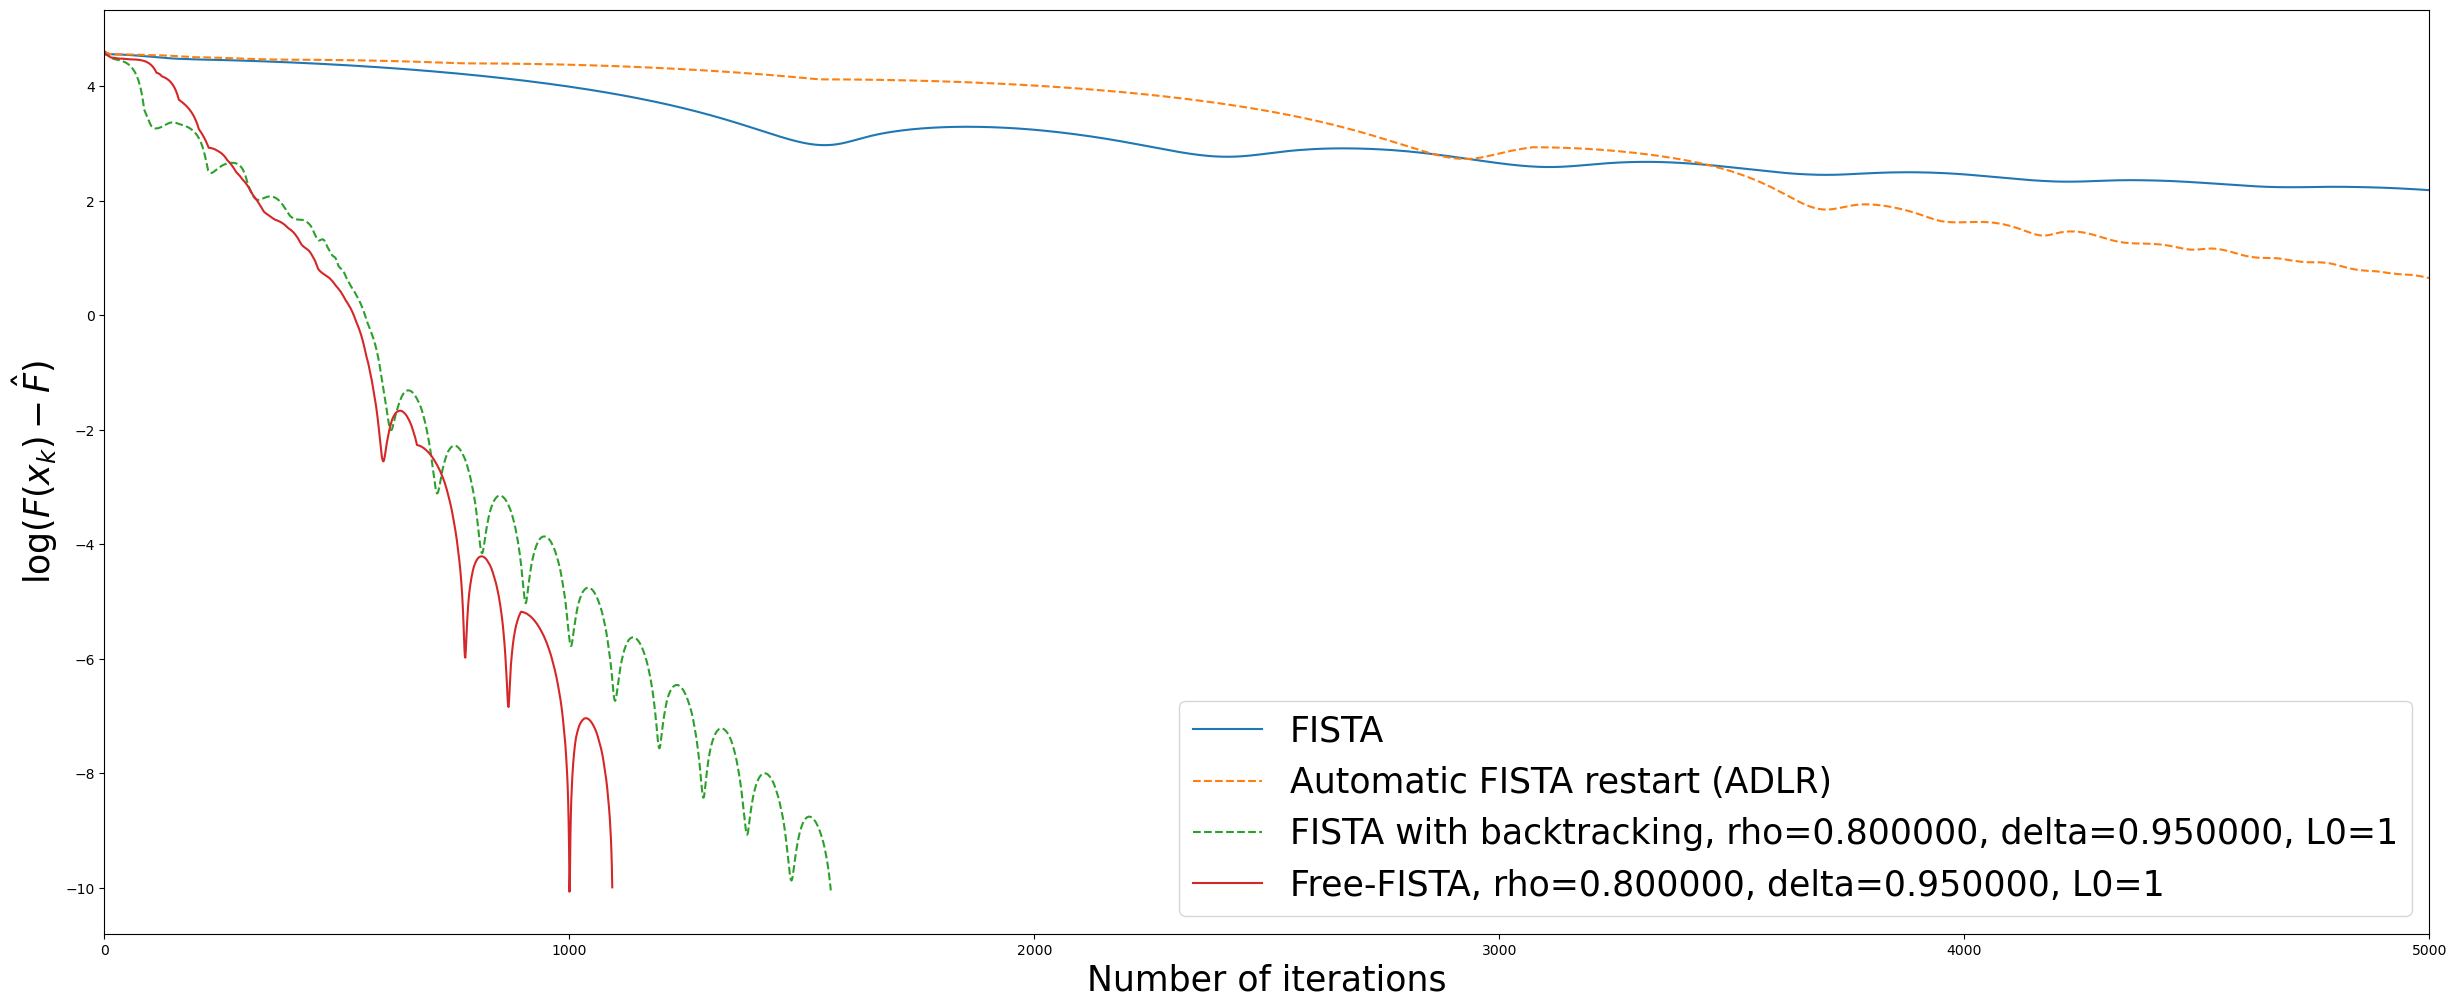

In [89]:
Plot([Plot_FISTA,Plot_AR1,Plot_BT1,Plot_BTR1],coutmin=F(xmin),style=['-','--','--','-'],fontsize=25)
plt.xlabel("Number of iterations",fontsize=25)
plt.ylabel("$\log(F(x_k)-\hat F)$",fontsize=25)

Text(0, 0.5, '$\\log(F(x_k)-\\hat F)$')

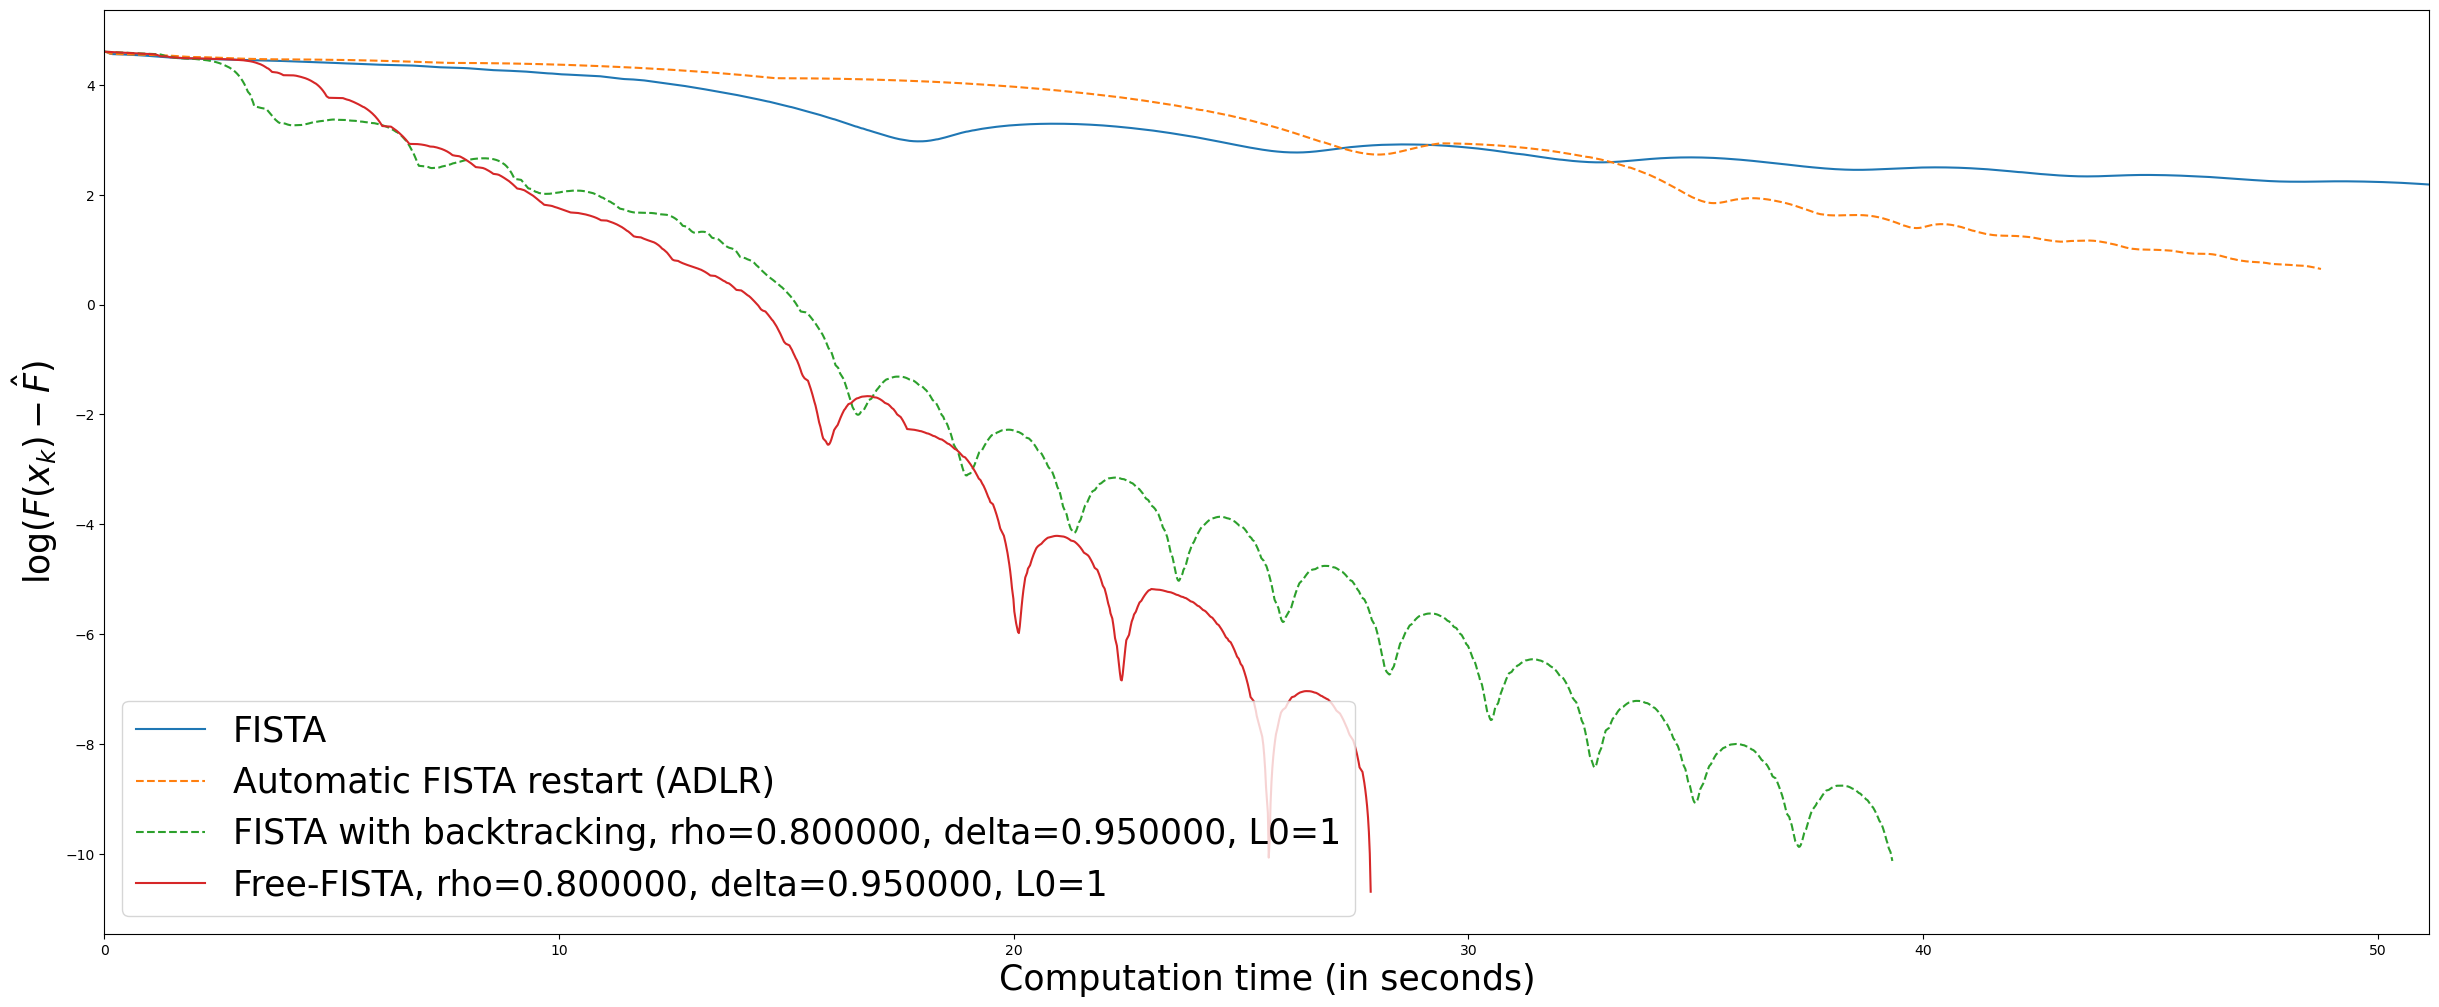

In [90]:
Plot([Plot_FISTA,Plot_AR1,Plot_BT1,Plot_BTR1],coutmin=F(xmin),style=['-','--','--','-'],ite=False,fontsize=25)
plt.xlabel("Computation time (in seconds)",fontsize=25)
plt.ylabel("$\log(F(x_k)-\hat F)$",fontsize=25)

### Comparing different choices of parameters

In [72]:
L0=L
rho=0.8
delta=0.95
xBTR,coutBTR2,ctimeBTR2,L_BTR2,ite_BTR2=Free_FISTA(x0, L0, rho, delta, Niter, epsilon, f, h, Df, proxh, exit_crit=exit_crit, sp=sp, out_cost=True, out_L=True, out_ite=True, exit_norm=True,track_ctime=True)
Plot_BTR2=To_Plot(coutBTR2,"Free-FISTA, rho=%f, delta=%f, L0=L (upper bound)"%(rho,delta),ctimeBTR2)

In [73]:
L0=1
rho=0.8
delta=0.99
xBTR,coutBTR3,ctimeBTR3,L_BTR3,ite_BTR3=Free_FISTA(x0, L0, rho, delta, Niter, epsilon, f, h, Df, proxh, exit_crit=exit_crit, sp=sp, out_cost=True, out_L=True, out_ite=True, exit_norm=True,track_ctime=True)
Plot_BTR3=To_Plot(coutBTR3,"Free-FISTA, rho=%f, delta=%f, L0=%i"%(rho,delta,L0),ctimeBTR3)

In [74]:
L0=L
rho=0.8
delta=0.99
xBTR,coutBTR4,ctimeBTR4,L_BTR4,ite_BTR4=Free_FISTA(x0, L0, rho, delta, Niter, epsilon, f, h, Df, proxh, exit_crit=exit_crit, sp=sp, out_cost=True, out_L=True, out_ite=True, exit_norm=True,track_ctime=True)
Plot_BTR4=To_Plot(coutBTR4,"Free-FISTA, rho=%f, delta=%f, L0=L (upper bound)"%(rho,delta),ctimeBTR4)

Text(0, 0.5, '$\\log(F(x_k)-\\hat F)$')

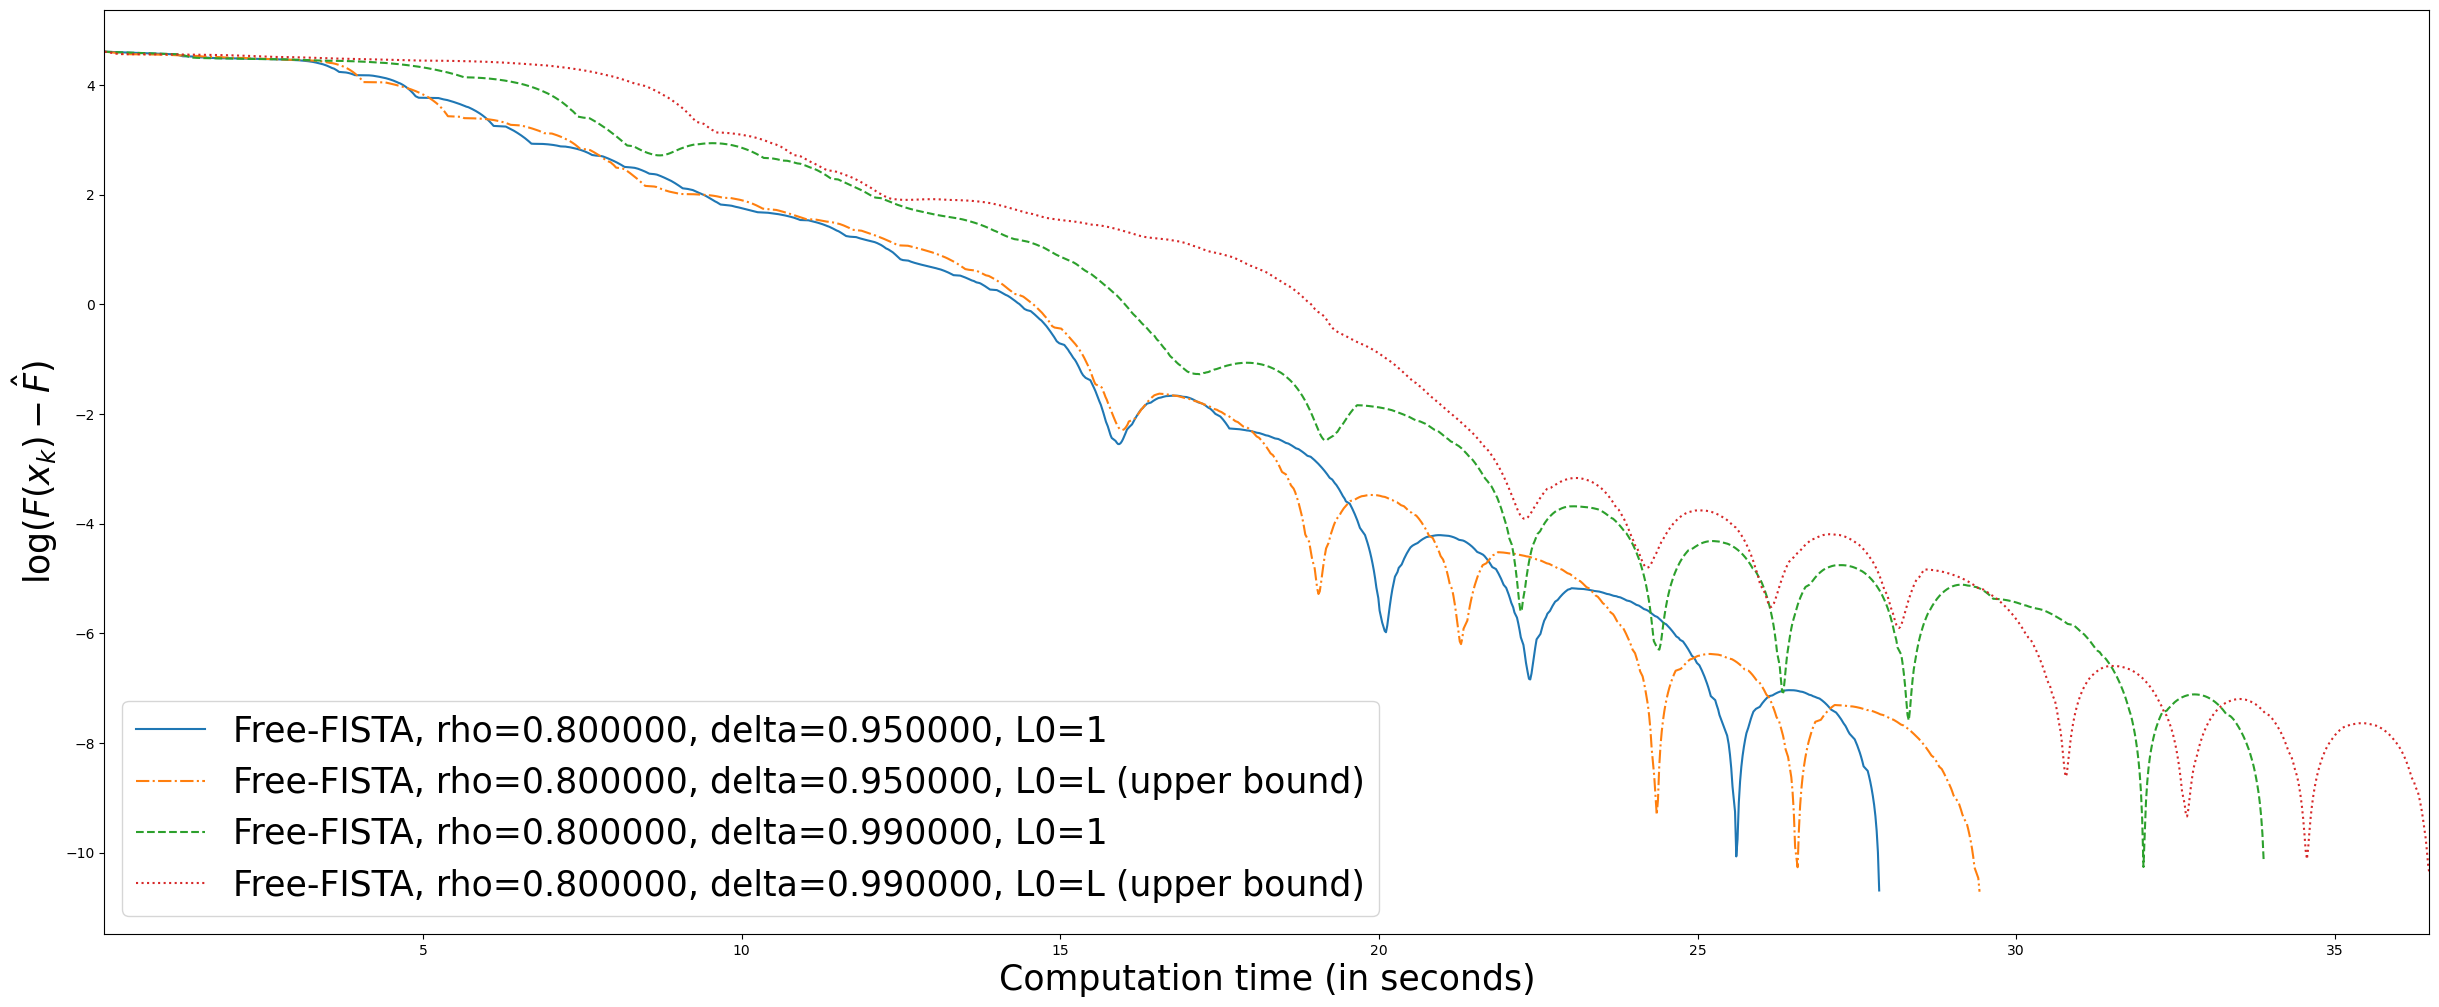

In [91]:
Plot([Plot_BTR1,Plot_BTR2,Plot_BTR3,Plot_BTR4],coutmin=F(xmin),style=['-','-.','--',':'],ite=False,fontsize=25)
plt.xlabel("Computation time (in seconds)",fontsize=25)
plt.ylabel("$\log(F(x_k)-\hat F)$",fontsize=25)

Comparing the theoric upper bound on $L$ and the values computed using backtracking

(0.0, 1218.0)

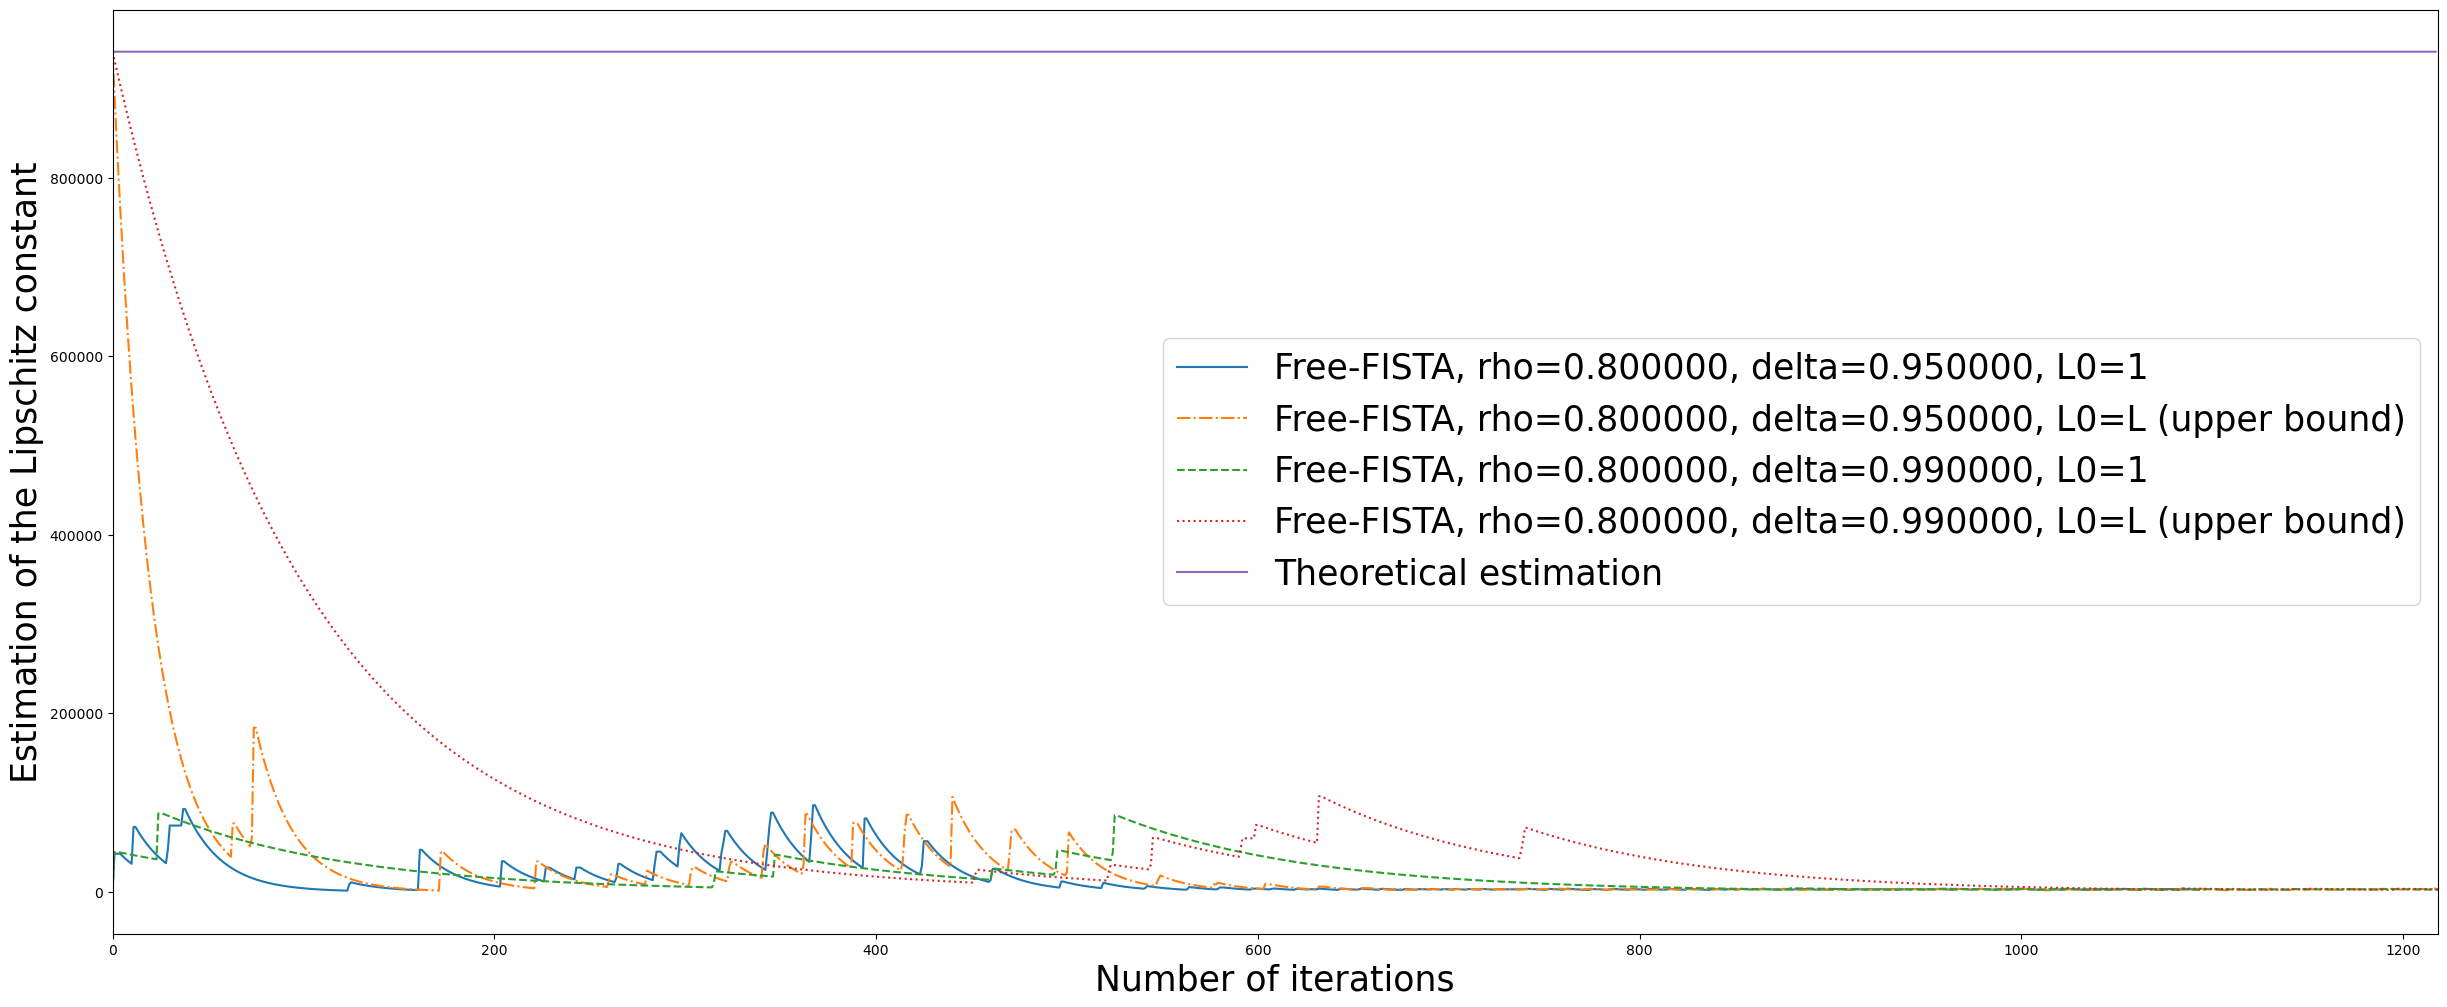

In [92]:
plt.plot(L_BTR1,'-')
plt.plot(L_BTR2,'-.')
plt.plot(L_BTR3,'--')
plt.plot(L_BTR4,':')
plt.plot(np.zeros_like(L_BTR2)+L)
plt.legend([Plot_BTR1.legend,Plot_BTR2.legend,Plot_BTR3.legend,Plot_BTR4.legend,"Theoretical estimation"],prop={'size': 25})
plt.ylabel("Estimation of the Lipschitz constant",fontsize=25)
plt.xlabel("Number of iterations",fontsize=25)
plt.xlim([0,len(L_BTR2)])

(-10.0, 1218.0)

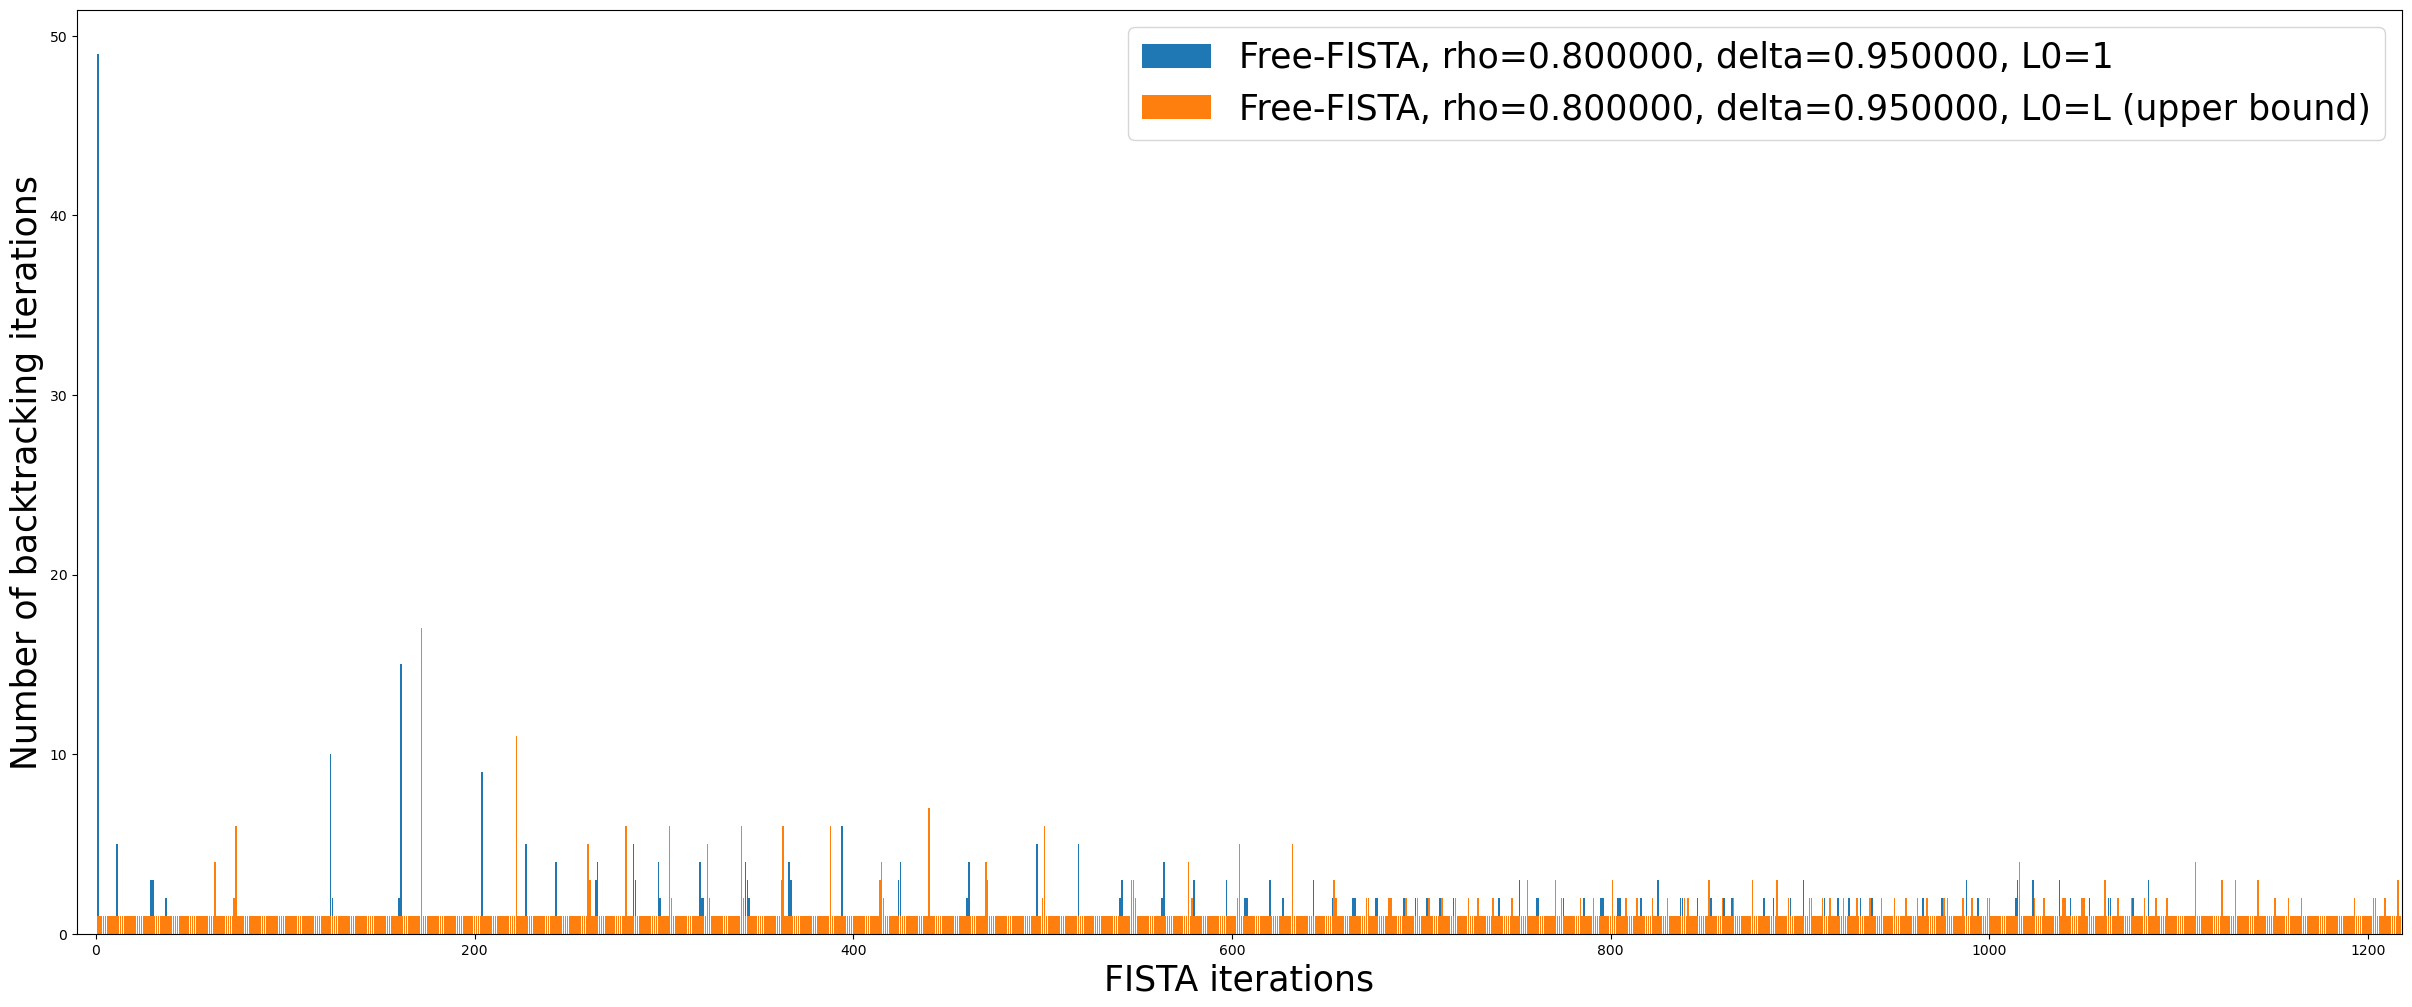

In [93]:
plt.bar(np.arange(0,len(ite_BTR1)),ite_BTR1)
plt.bar(np.arange(0,len(ite_BTR2)),ite_BTR2)
plt.legend([Plot_BTR1.legend,Plot_BTR2.legend],prop={'size': 25})
plt.xlabel("FISTA iterations",fontsize=25)
plt.ylabel("Number of backtracking iterations",fontsize=25)
plt.xlim([-10,len(ite_BTR2)])